In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

        

In [3]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [15]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    BatchNorm(6, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    BatchNorm(16, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16*4*4, 120), 
    BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [16]:
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm()
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm()
  (6): Sigmoid()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm()
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm()
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)

loss 0.239, train acc 0.915, test acc 0.884
65421.2 examples/sec on cuda:0


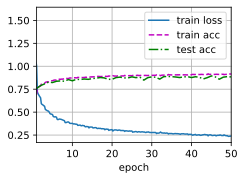

In [9]:
lr, num_epochs, batch_size = 0.1, 50, 1024
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [19]:
# 简洁实现

In [20]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.BatchNorm2d(6), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120), 
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84), 
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.394, train acc 0.862, test acc 0.836
83194.6 examples/sec on cuda:0


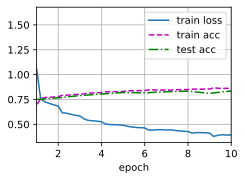

In [21]:
lr, num_epochs, batch_size = 0.3, 10, 1024
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())